In [68]:
from jax import grad, jit, jacrev, jacfwd

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def M2(A1,A2):         
    A1,A2 = set(A1),set(A2)
    return len(A1.intersection(A2))/np.sqrt(len(A1)*len(A2))

## Load all groups generated with script

grps={}
for yr in range(1800,2018,2):
    try:
        fh = open(f'foundGroups/grp{yr}.bin','rb')
        grps[yr] = pickle.load(fh)[1]
    except: 
        grps[yr] = grps[yr-2].copy() # Just copy results from previous year as there was an error  
        print(f"{yr} not found")

1864 not found


In [133]:
class HistGraph():
    """The whole graph, not limited to MIN/MAX_YR. 
    Methods plot and optimize are restricted tho. So opt can be carried out in windows.
    
    nodes: dict(yr: [list of groups])
    """
    def __init__(self,nodes):
        # First df for nodes (groups) and initialize x var for each
        node_idd = [(f"{yr}_{id}",nodes[yr][id],yr) for yr in nodes.keys() # List of (id,grp) for all groups
                                    for id,_ in enumerate(nodes[yr])] 
        node_id,node_unwr,node_yr = list(zip(*(node_idd))) # Unwrap in full list of ids and list of groups
        self.node_df = pd.DataFrame({"name":node_id,
                                     "x":np.random.random(len(node_id))*2,
                                     "elems":node_unwr,
                                     "yr":node_yr})
        self.node_df["z"] = np.random.random(len(node_id))*2 # Add z var for flexibility
        map_name_ind = dict(zip(node_id,self.node_df.index))
        
        # Second, df for edges
        edges = []
        for yr in nodes.keys():
            for id1,gr1 in enumerate(nodes[yr]):  
                # Include connections between different years
                if yr<max(nodes.keys()): # So yr+2 won't be a problem
                    for id2,gr2 in enumerate(nodes[yr+2]): 
                        m2 = M2(gr1,gr2)
                        dist = 1-m2 + 1.2 # 1.2 for scaling. if 1-dist==1 -> k~2.2~sqrt(5): diagonal 
                        v = [f"{yr}_{id1}",f"{yr+2}_{id2}",yr,yr+2,dist,m2]  
                        edges.append(v)

                # Include connections between groups of same year 
                id2=id1
                for gr2 in nodes[yr][id1+1:]:
                    id2+=1
                    # Add 0.05 so groups are still distinguishable.
                    m2=M2(gr1,gr2)
                    dist = 1-m2 + 0.05
                    v = [f"{yr}_{id1}",f"{yr}_{id2}",yr,yr,dist,m2] 
                    edges.append(v)   
        
        self.edges = pd.DataFrame(edges,columns=['yr_id1','yr_id2','yr1','yr2','k','m2'])
        # Map the indices for then mapping the x coords
        self.edges["grp1_ind"] = self.edges["yr_id1"].apply(lambda x: map_name_ind[x])
        self.edges["grp2_ind"] = self.edges["yr_id2"].apply(lambda x: map_name_ind[x])  

    def Optimize(self,MIN_YR,MAX_YR,EPOCHS=1000,lr=1e-3,v=500):
        """Optimize locally points in the range [MIN_YR,MAX_YR] (including both!)
        v controls verbosity: Frequency of output, cost is printed every `v` iterations.
        v=0: no output"""
        # Gradient of energy w.r.t. xs
        gradient = jit(grad(energy))

        # Query only edges involving the year range of interest
        quer1 = (self.edges.yr1>=MIN_YR)&(self.edges.yr2>=MIN_YR)
        quer2 = (self.edges.yr1<=MAX_YR)&(self.edges.yr2<=MAX_YR)
        opt_edges = self.edges[quer1&quer2]
        
        # Get inputs for energy
        grp1_ind,grp2_ind = opt_edges.loc[:,["grp1_ind","grp2_ind"]].values.T
        yr1,yr2 = opt_edges.loc[:,['yr1','yr2']].values.T  #ys
        z1,z2 = self.node_df["z"].values[grp1_ind],self.node_df["z"].values[grp2_ind]
        ks = opt_edges.loc[:,'k'].values
        args = (grp1_ind,grp2_ind,yr1,yr2,z1,z2,ks)
        
        # Opt loop (just basic grad descent)
        costs = []
        best_cost,best_xs=np.inf,None
        xs = self.node_df["x"].values

        CHECK_FREQ,tol = 50,10
        for e in range(EPOCHS):
            df = gradient(xs,*args)  # Calc grad
            xs -= lr*df  # Update xs_all using grad
            E = energy(xs,*args)
            
            ## Handle E = nan
            if np.isnan(E):
                xs = best_xs
                lr /= 5
            
            if E<best_cost:
                best_cost = E
                best_xs = xs

            # Break loop if in plateau
            if e%CHECK_FREQ==0:    costs.append(E)            
            if len(costs)>4:
                dif = np.abs(np.diff(costs[-5:])) # Check last 4 costs
                if np.mean(dif)<tol:    break
                
            if v!=0: 
                if e%v==0:  print(e,E); lr/=2
                    
        print(f"Best cost = {best_cost}")
        self.node_df["x"] = best_xs  # Set best solution

    def plotGraph(self,MIN_YR,MAX_YR,THRESH=0.0,seed=False,
                  figsize=(20,5),title="",save=False):
        """Plot nodes and edges in range [MIN_YR, MAX_YR]. 
        Edges are plotted above THRESH [0,1], and color intensity is based on k.
        
        seed: list of [grp_ids] used as a seed to propagate the graph. 
            Only significant connections (M2>THRESH) to such groups will be plotted.
        """
        ## Query on seed: get only relevant nodes+edges
        yr_seed, edges, nodes = self.__queryOnSeed(seed,THRESH)
        
        fig,ax = plt.subplots(figsize=figsize)
            
        # Draw edges.
        quer1 = (edges.yr1>=MIN_YR)&(edges.yr2>=MIN_YR)
        quer2 = (edges.yr1<=MAX_YR)&(edges.yr2<=MAX_YR)
        plot_edges = edges[quer1&quer2].copy() # Query only relevant ones
        plot_edges["x1"] = nodes.loc[plot_edges.grp1_ind.values,'x'].values  # Map xs for each node
        plot_edges["x2"] = nodes.loc[plot_edges.grp2_ind.values,'x'].values

        for e in range(plot_edges.shape[0]):
            yr1,yr2,x1,x2,k = plot_edges.iloc[e].loc[["yr1","yr2","x1","x2","k"]].values
            
            if yr1!=yr2 and 1-(k-1.2)>THRESH: # plot edges only between different years. and sim>THRESH
                alpha = (1-(k-1.2)-THRESH)/(1-THRESH)#*(1-k>THRESH)
                ax.plot([yr1,yr2],[x1,x2],
                        alpha=alpha,color='k',zorder=-1)
                
        # Draw nodes
        for yr in range(MIN_YR,MAX_YR+2,2):
            ax.axvline(yr,color='k',linewidth=0.5,zorder=-1)      # A line for each year
            
            # Get coords of each group for this year.
            xs = nodes.loc[nodes.yr==yr,"x"].values
            ys = np.repeat(yr,xs.shape[0])
            
            if yr==yr_seed: kwargs=dict(marker='*',color='r',s=205)
            else:           kwargs=dict()
            ax.scatter(ys,xs,zorder=1,**kwargs) #Plot groups for this year, represented each as a point   
    
        # Make plot cute <3
        ax.set_xlim(MIN_YR-0.1,MAX_YR+0.1)
        #ax.set_ylim(-0.1,2.1)
        ax.set_title(title,fontsize=25)
        ax.set_xticks(range(MIN_YR,MAX_YR+2,2))
        ax.axes.get_yaxis().set_visible(False) # Remove yaxis labels
        # Remove all spines
        for _ in ['top','bottom','left','right']:    ax.spines[_].set_visible(False)
          
        if save: plt.savefig(save,dpi=200)
        plt.show()
        
    def __queryOnSeed(self,seed,THRESH): 
        """    Return new graph specification (edges,nodes) 
        containing only edges+nodes connected significantly to nodes specified in `seed`.
        `Significantly` meaning there's a chain of edges with M2>THRESH, 
            connecting an object to any of said nodes.
        All nodes in `seed` should be in the same year (for now at least)
        """
        yr_seed = int(seed[0].split("_")[0]) # Extract year of selection
        keep_nodes = seed   # List to store nodes that "pass" selection

        # First take all edges with relevant M2
        edges = self.edges[self.edges['m2']>THRESH]
        # Take only edges associated with nodes in seed
        relev_ed = edges[(edges.yr_id1.isin(seed) | edges.yr_id2.isin(seed))]

        #Now propagate to the past. 
        #From these nodes, take only those in 2 yrs before, and search only in the past.
        #By construction, yr1<=yr2, so to look in the past you need only look at yr1. (yr2 bzw. for futur)
        p_yr = yr_seed
        past_seed = relev_ed.loc[relev_ed.yr1<p_yr,'yr_id1'].values
        while True:
            p_yr-=2
            keep_nodes += list(past_seed)
            # Find edges participating in relevant edges with nodes in past_seed, in year before
            past_seed = edges[edges.yr_id2.isin(past_seed) & (edges.yr1<p_yr)].yr_id1.unique()  
            if len(past_seed)==0: break

        # Propagate into future, same principle
        f_yr = yr_seed
        futr_seed = relev_ed.loc[relev_ed.yr2>f_yr,'yr_id2'].values
        while True:
            f_yr+=2
            keep_nodes += list(futr_seed)
            futr_seed = edges[edges.yr_id1.isin(futr_seed) & (edges.yr2>f_yr)].yr_id2.unique()  
            if len(futr_seed)==0: break

        # Now query edges, such that both nodes are in keep_nodes
        edges = self.edges[(self.edges.yr_id1.isin(keep_nodes) & 
                            self.edges.yr_id2.isin(keep_nodes) & 
                            self.edges.m2>THRESH)].copy()
        nodes = self.node_df[self.node_df.name.isin(keep_nodes)].copy()
        
        return yr_seed,edges, nodes
        


##### END class definition
        
@jit  # Energy function definition
def energy(xs,grp1_ind,grp2_ind,yr1,yr2,z1,z2,ks): 
    """
    Calculate potential energy between nodes. 
    xs: The only variables. Shape is total number of groups. 
    grp{i}_ind: int array for indexing xs. 
        Local Energy calcs (thus opts) are controlled through this and yr{i}
    yr{i}: indexed year."""
    grp1_x = xs[grp1_ind]
    grp2_x = xs[grp2_ind]
    dists = (grp1_x - grp2_x)**2 + (yr1 - yr2)**2 + (z1-z2)**2
    energ = np.sum(2*dists/ks + ks**2/(dists)**2)  
    return energ

In [136]:
MIN_YR,MAX_YR = 2000,2006

g=HistGraph(grps)
g.Optimize(MIN_YR,MAX_YR,EPOCHS=5000,lr=1e-2)

0 9.602568e+17
500 1902909000000.0
1000 18442078000.0
1500 126192640.0
2000 1453996200000.0
2500 63373027000000.0
3000 4353159000.0
3500 70527256.0
4000 20173504.0
4500 13805119.0
Best cost = 3771254.75


## TO-DO

- [x] Unclutter visualization. There's no point in plotting all points if you can't see a thing.
    - Select points to plot based on connections to relevant points and THRESH.
    - Pass a list of [grp_ids] as an argument. Limit to a single year for now.
        - Query df to only plot significant connections (M2 > THRESH).
        - Evolve into past and into future from that point, only showing significant connections to accepted points.
        


- [ ] Optimize only on the selected sub-network (selected on step 1).
    - Basically just filter edges by nodes selected.



- [ ] Optimize locally, sequentially with overlaps: e.g. opt. 1800-1806, then 1804-1810, ...

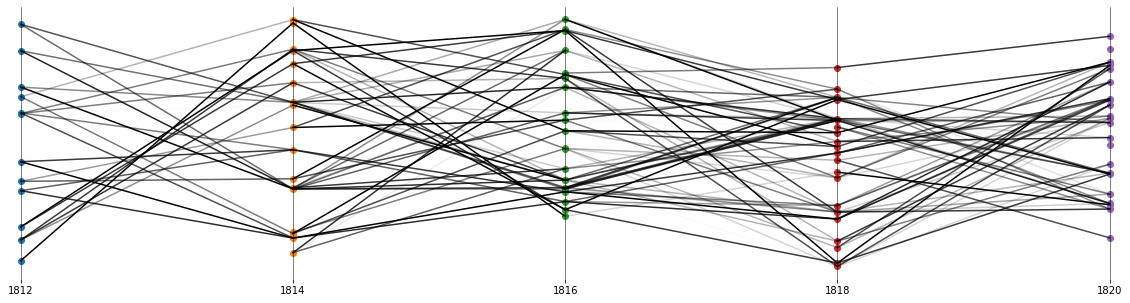

In [225]:
mi,ma=1812,1820

a = HistGraph(grps)
a.plotGraph(mi,ma,0.4)
#a.Optimize(mi,ma,EPOCHS=20000,LR=1e-4,v=3000)

## Create a kind of circular, divergent chord diagram.

Concentric circles represent years, with inner circles being earlier years.

Groups are shown as they appear. Each group in year X is connected to every group in year X+2, intensity of connection is given by similarity between said pair of groups.

## Let's start simple, by just using a flat version, with years being represented by lines, lowest year at the bottom.

### Algorithm:

Compute relations for every pair of groups yearly (X -> X+2, then X+2 -> X+4, etc).

---

### If I were to optimize the whole graph all at once, I'd need to define some stuff. Let's do that here.

- Cost function (optimization objective).
    - Include connections between points in year back and forward in time.
    - Include connections between points in same year: similar groups are clustered.
    - Give fixed coordinates to first year's groups.
    
### Calculate this as if it were a system of springs. 
Use energies derived from the forces presented in [SOFTWARE-PRACITCE AND  EXPERIENCE,  VOL.  21(11),  1129-1164  (NOVEMBER 1991)](https://reingold.co/force-directed.pdf). They, however, don't count for different weights on edges, so we need to account for that in parameter k.

For them, k is the optimal distance between nodes, here we want to calculate an optimal distance based on similarities.

$$
\begin{equation}
P = \sum_i^{|E|} \frac{2x_i}{k_i}  + \frac{k_i^2}{x_i^2}
\end{equation}
$$  

Nice properties of this function:
    - k has straightforward interpretation: Is optimal distance between a pair of nodes.
    - Large gradient when k small and viceversa. Closeness is further encouraged by this, when similiarity is high.

Let's then define $k_i$ as: $k_i = 1 - Sim$



- Restricted optimization: 
    - Points are necessarily on the vertical corresponding to the year.
    - Check if restriction to [0,1] is necessary.

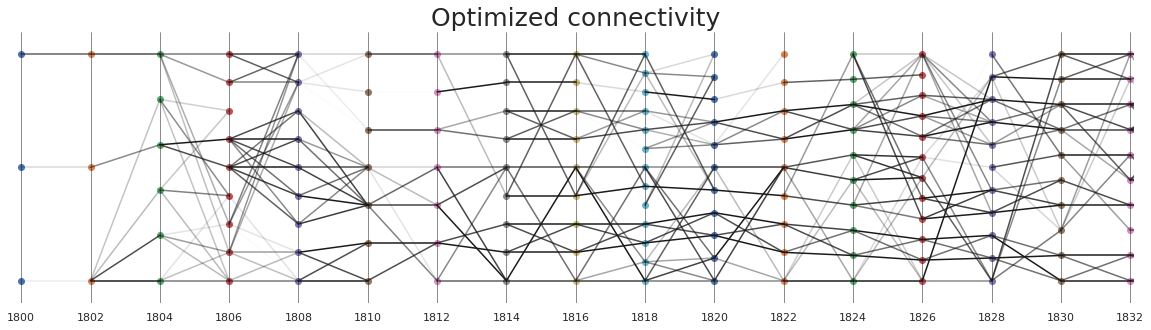

In [17]:
MIN_YR,MAX_YR,THRESH = 1800,1832,0.4
chordDiag(MIN_YR,MAX_YR,THRESH,opt_kws={"Bool":True,"popSize":300,"NGens":50,"mutRate":0.7,"T":0.7,
                                        "costF":costEntanglCoord,"verbose":False},
         title="Optimized connectivity")

### Try to optimize orderings of each year's groups, so that lines don't overlap as much.

Idea: Use a greedy algorithm, don't care about global "unclutteredness", but propagate local optimization.

It all depends on the connectivity matrices. Check them and see what the optimization should be about.


### We need these matrices to be as diagonal as possible! 

Meaning: we may need genetic algorithms again. This time though, matrices are non-symmetric, and as we're propagating local features, we only need to reshuffle the columns of the matrices (and the corresponding groups).


#### I'll just reuse code, but as it wasn't written for a general problem I will do some minor modifications

- Like the cost function
- Resorting protocol, as only columns are being swapped (no correlation with rows).


## Cost function definition (E) for entanglement

\begin{equation}
E = - \sum_i^{N_x} \sum_j^{N_y} \frac{CM_{ij}}{|i-j|+\epsilon}
\end{equation}

Where we need to add $\epsilon$ in the denominator, as $i$ can be (ideally) equal to $j$.

### Note: This will lead to some weird results, as we're optimizing in the index space, which will lead to strongest lines being all to the same side.

We need to take optimization to coordinate space (y axis on our plot). To do so, we just need to normalize indices `i` and `j` by the correspondent matrix size.

## Cost function definition (E') in coordinate space.


\begin{equation}
E' = - \sum_i^{N_x} \sum_j^{N_y} \frac{CM_{ij}}{|\frac{i}{N_x}-\frac{j}{N_y}|+\epsilon}
\end{equation}


In [218]:
class Individual:
    def __init__(self,N,costF,gen=False,P=False):
        self.N = N
        self.P = P
        if type(gen)!=bool:            self.gen = gen
        else:              self.gen = np.random.permutation(self.N)
        self.costF = costF
        self.cost = self.costF(self.P,self.gen)

    def PMX(self,parent):
        """Partially-mapped crossover (PMX)
        Assumes NParents=2
        parent is an `Individual` object containing the other parent"""
        NParents = 2
        
        offsp = -np.ones((NParents,self.N),dtype=np.short)
        cutpts = np.sort(np.random.randint(1,self.N-1,2))
        
        m0,m1 = self.gen[cutpts[0]:cutpts[1]] , parent.gen[cutpts[0]:cutpts[1]]
        # Define initial mapping
        offsp[0,cutpts[0]:cutpts[1]] = m1
        offsp[1,cutpts[0]:cutpts[1]] = m0
        
        ### Start filling
        offsp[0,:cutpts[0]] = self.gen[:cutpts[0]]
        offsp[1,:cutpts[0]] = parent.gen[:cutpts[0]]
        offsp[0,cutpts[1]:] = self.gen[cutpts[1]:]
        offsp[1,cutpts[1]:] = parent.gen[cutpts[1]:]
        
        map0 = dict(zip(m1,m0))
        map1 = dict(zip(m0,m1))
        
        for i in range(cutpts[0]):
            while offsp[0,i] in m1:
                offsp[0,i] = map0[offsp[0,i]]
            while offsp[1,i] in m0:
                offsp[1,i] = map1[offsp[1,i]]
              
        for i in range(cutpts[1],self.N):
            while offsp[0,i] in m1:
                offsp[0,i] = map0[offsp[0,i]]
            while offsp[1,i] in m0:
                offsp[1,i] = map1[offsp[1,i]]
                
        return [Individual(self.N,costF=self.costF,gen=offsp[i],P=self.P) for i in range(2)]
    
    def mutate(self):
        """Move a random slice of the genes to a random place"""
        
        indiv = self.gen
        cutpts = np.sort(np.random.randint(0,self.N,2))
        Slice = indiv[cutpts[0]:cutpts[1]].copy()
        
        Left = np.concatenate([indiv[:cutpts[0]],indiv[cutpts[1]:]])              
        move_to = np.random.randint(0,Left.shape[0])
        
        self.gen = np.concatenate([Left[:move_to],Slice,Left[move_to:]]) 
        self.cost = self.costF(self.P,self.gen) # Update cost
    
class Population:
    def __init__(self,size,N,costF,NParents=2,gens = False,Indivs=False,bestIndiv=False,seed=0,P=False):
        self.size = size  # Number of individuals
        self.N = N        # Number of elements in dataset
        self.NParents = NParents # Number of parents for a single breed
        self.seed = seed
        self.P = P
        self.costF = costF
        
        np.random.seed(int(time()+seed))
        if not Indivs:
            if gens:        self.indivs = [Individual(N,costF=self.costF,gen=gens[i],P=self.P) for i in range(size)]
            else:           self.indivs = [Individual(N,costF=self.costF,P=self.P) for i in range(size)]
        else:               self.indivs = Indivs
            
        self.costs = [i.cost for i in self.indivs]
        
        ### Store best global configuration
        if bestIndiv:     
            self.bestIndiv = bestIndiv
            self.bestCost = bestIndiv.cost
        else:
            self.bestIndiv = False
            self.bestCost = 0
        
    def minCost(self):
        return np.min(self.costs)
    def meanCost(self):
        return np.mean(self.costs)
    def getBestIndiv(self):
        return self.indivs[np.argmin(self.costs)]
    
    def partnerUp(self):
        """Create a group of individuals for crossover"""
        parents = []
        idx = np.random.choice(np.arange(self.size),size=self.NParents,replace=False,p=self.probs)
        for i in idx:
            parents.append(self.indivs[i])
        return parents
    
    def newBreed(self,crossover,mutRate):
        newIndivs = []
        for i in range(self.size//2):
            parents = self.partnerUp()  # Select couples
            
            # Do crossover on these parents
            if crossover == 'PMX':        indivs_i = parents[0].PMX(parents[1])
    
            # Mutations
            for i in range(self.NParents):
                # Mutate each child with probability mutRate
                if np.random.random() < mutRate:    indivs_i[i].mutate()
                
            newIndivs = newIndivs + indivs_i
        return newIndivs
            
    def evolve(self,NGeners,T=0.7,crossover='PMX',mutRate=0.1):
        for i in range(NGeners):
            # Probabilites of breeding for each individual
            # Use Boltzmann's distrib. with T. A lower T means an more uneven distribution (~ 0.x)
            self.probs = np.exp(-(np.array(self.costs)-min(self.costs))/T)
            #self.probs = np.array([np.exp(-cost/T) for cost in self.costs])
            Z = np.sum(self.probs)
            self.probs = self.probs/Z
            #while self.probs.isna().any():
                
            
            self = Population(self.size,self.N,bestIndiv=self.bestIndiv,seed=self.seed,
                              Indivs=self.newBreed(crossover,mutRate),P=self.P,costF=self.costF)
            
            minc,meanc = self.minCost(), self.meanCost()
            if minc < self.bestCost:
                self.bestIndiv = self.getBestIndiv()
                self.bestCost = self.bestIndiv.cost
                
            #if i%50==0:
            #    print(f"** Iter No. {i}, Mean = {meanc:.3f}, Min = {minc:.3f}, P{self.seed}")
        return self

In [215]:
def costEntangl(CM,gen=False):
    """Calculate a cost associated to the entangledness of connectivity matrix CM.
    For CM_{ij} large, we want j to be as close to i as possible.
    Gen is the new ordering. If False, use as is"""
    if type(gen)!=bool:
        CM = CM[:,gen]
    
    # Create two arrays indicating index, based on CM shape
    xsh,ysh = CM.shape
    xv,yv = [a.ravel() for a in np.meshgrid(range(ysh),range(xsh))]
    CM = CM.ravel()
    
    return -np.sum(CM/(np.abs(xv-yv)+1e-1))

def costEntanglCoord(CM,gen=False):
    """
    Cost function in coordinate space
    Calculate a cost associated to the entangledness of connectivity matrix CM.
    For CM_{ij} large, we want j to be as close to i as possible.
    Gen is the new ordering. If False, use as is."""
    if type(gen)!=bool:
        CM = CM[:,gen]
    
    # Create two arrays indicating index, based on CM shape
    ysh,xsh = CM.shape
    xv,yv = [a.ravel()/(CM.T.shape[dim]-1) for dim,a in enumerate(np.meshgrid(range(xsh),range(ysh)))]

    CM = CM.ravel()
    
    return -np.sum(CM/(np.abs(xv-yv)+1e-1))

In [216]:
def optPop(Pi,kws={"popSize":100,"NGens":100,"costF":costEntanglCoord,
                   "mutRate":0.5,"T":0.8,"verbose":False}):
    popSize,costF,NGens,T,mutRate = kws["popSize"],kws["costF"],kws["NGens"],kws["T"],kws["mutRate"]
    lenElems=Pi.shape[1]
    breed = Population(popSize,lenElems,costF=costF,P=Pi).evolve(NGens,T=T,mutRate=mutRate)
    
    cost1 = costF(Pi)
    if kws["verbose"]:    print(f"Init cost {cost1:.3f}, Fin cost {breed.bestCost:.3f}")
    return breed

def connectMatrix(b1,b2):
    """Return connectivity matrix between bags b1 and b2"""
    m=np.zeros((len(b1),len(b2)))
    for i,g1 in enumerate(b1):
        for j,g2 in enumerate(b2):
            m[i,j] = M2(g1,g2)
    return m

def chordDiag(MIN_YR,MAX_YR,THRESH,figsize=(20,5),title="",
              opt_kws={"Bool":True,"popSize":100,
                       "NGens":100,"costF":costEntanglCoord,"mutRate":0.5,"T":0.8,
                       "verbose":False}):
    """Produce a chord diagram showing the evolution of groups, from MIN_YR to MAX_YR.
    This plots a line between every group in year X with every other in X+2, whose similarity is > THRESH.
    Intensity of line correlates with similarity.
    Optimization is performed (if opt_kws provided) to reduce entanglement of strong lines, so plot is clearer.
    
    opt_kws = {T,popSize,NGens,Bool}. Bool indicates if optimizing or not
    """
    grps_cp = grps.copy()  # We're changing the order of groups. Don't mess with original list

    fig,ax = plt.subplots(figsize=figsize)

    MIN_YR += 2 # Just for convenience, as we do things with yr-2. Problematic cause 1798 doesn't exist
    ax.set_xlim(MIN_YR-2.1,MAX_YR+0.1)
    ax.set_ylim(-0.1,1.1)
    ax.set_title(title,fontsize=25)
    ax.set_xticks(range(MIN_YR-2,MAX_YR+2,2))
    ax.axes.get_yaxis().set_visible(False) # Remove yaxis labels
    # Remove all spines
    for _ in ['top','bottom','left','right']:    ax.spines[_].set_visible(False)

    for nyr,yr in enumerate(range(MIN_YR-2,MAX_YR+2,2)):
        # A line for each year
        ax.axvline(yr,color='k',linewidth=0.5)  

        grpCurr = grps_cp[yr]
        grpNext = grps_cp[yr+2]

        # Calculate conexion matrix
        CM = connectMatrix(grpCurr,grpNext) # Get all coefficients

        # Rescale to [0,1] by using transform (x-THRESH)/(1-THRESH)
        # Then mask coefficients to remove all below THRESH
        CM = (CM-THRESH)/(1-THRESH)*(CM>THRESH) 

        # If all in a col are zero, don't plot that point
        notkeep=CM.sum(axis=0)==0
        CM=np.delete(CM,notkeep,axis=1)

        # Now update group next year (remove every group that's not connected to any other group in previous yr)
        newGrpNext = []
        for i,g in enumerate(grps_cp[yr+2]):
            if not notkeep[i]: newGrpNext.append(g)

        # If no groups found for this year, we'll have an issue
        if len(grps_cp[yr])==0: raise Exception("Decrease THRESH!")

        if opt_kws["Bool"]:
            # Optimize connectivity locally
            popul = optPop(CM,kws=opt_kws)
            CM = CM[:,popul.bestIndiv.gen] # Resort using optimized order
            # Change order of next group in list, as optimized
            grps_cp[yr+2] = [newGrpNext[i] for i in popul.bestIndiv.gen]  
        else:
            grps_cp[yr+2] = newGrpNext

        # Get coords of each group for this year.
        if len(grps_cp[yr])>1:  dots = np.linspace(0,1,len(grps_cp[yr]))
        else:                   dots = [0.5]
        yr_dots = np.repeat(yr,len(grps_cp[yr]))
        ax.scatter(yr_dots,dots) #Plot groups for this year, represented each as a point

        # Get coords for groups next year
        if len(grps_cp[yr+2])>1:  dots_Next = np.linspace(0,1,len(grps_cp[yr+2]))
        else:                     dots_Next = [0.5]

        # Now draw connections
        for i in range(CM.shape[0]):
            for j in range(CM.shape[1]):
                ax.plot([yr,yr+2],[dots[i],dots_Next[j]],alpha=CM[i,j],color='k')        

    ax.invert_yaxis()
    plt.savefig("./EvolGroups.png",dpi=200)
    plt.show()

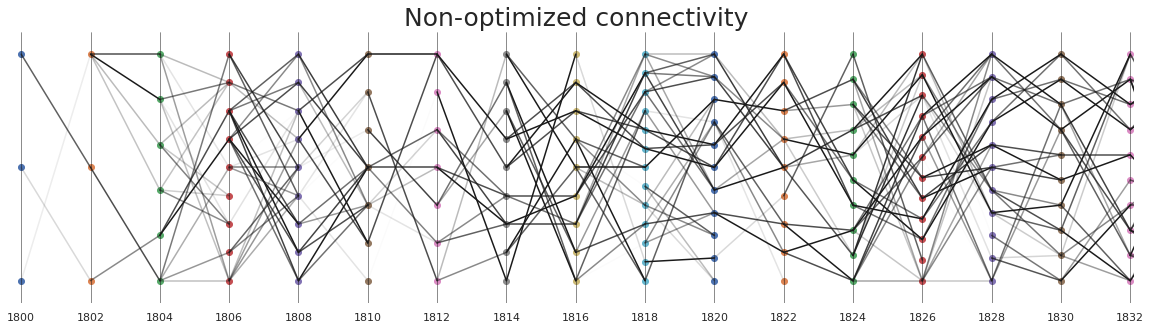

In [12]:
MIN_YR,MAX_YR,THRESH = 1800,1832,0.4
chordDiag(MIN_YR,MAX_YR,THRESH,opt_kws={"Bool":False},title="Non-optimized connectivity")

In [ ]:
MIN_YR,MAX_YR,THRESH = 1800,1832,0.4
chordDiag(MIN_YR,MAX_YR,THRESH,opt_kws={"Bool":True,"popSize":300,"NGens":50,"mutRate":0.7,"T":0.7,
                                        "costF":costEntanglCoord,"verbose":False},
         title="Optimized connectivity")

### Looking good!

# Next steps:

- Reduce computation as much as possible. Store optimized orderings for the whole thing (THRESH=0), and assume removing cols below THRESH!=0 will be a good aproximation.

- Work on a circular representation of this. Basically just map what we already have into polar coords.
  
- Produce interactive version using Plotly. This would allow to see what each group is about and directly explore evolution.
    - Could in principle be very long in horizontal direction, with a bar to hover bar to explore different epochs.
    - Add a bar for modifying value of THRESH.
    - When clicking on a given group, highlight it's whole future. Like show the network that is produced from that group, highlighting stronger connections.
    - Include a PT, so that when a group is hovered, that group's elements are highlighted in our PT.

- Change the way in which points are plotted. They not necessarily should be equally distanced from each other, but clusters of very similar groups in a given year should have smaller distances. 
    - Include this in the cost function (obviously, as it works in coord space).
    - Restrict with a minimum distance tho, as we don't want to see a single point instead of 4, we wanna see them all.

In [20]:
## Now evolve each of the found groups to the future.
# If group `g` is found new on year X, find most similar group to `g` in year X+2, and store M2.

grpsEvol = []
for G,yr in newGrps:
    yrEvol=yr
    evol_grp = []
    evol_M2 = []
    while yrEvol<2017:
        grps_yrNex = grps[yrEvol] # Next year
        G,sim = getMostSimTo(G, grps_yrNex) # Most sim group in next year
        evol_grp.append(G)
        evol_M2.append(sim)
        
        yrEvol+=2
        
    grpsEvol.append((yr,evol_grp,evol_M2))

grpsEvol

[(1802,
  [{'Ag', 'H', 'K', 'Na'},
   {'Ag', 'H', 'K', 'Na'},
   {'Ag', 'Hg', 'K', 'Na'},
   {'Ag', 'H', 'K', 'Na'},
   {'Ag', 'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'K', 'Na'},
   {'Ag', 'H', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'H', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K'

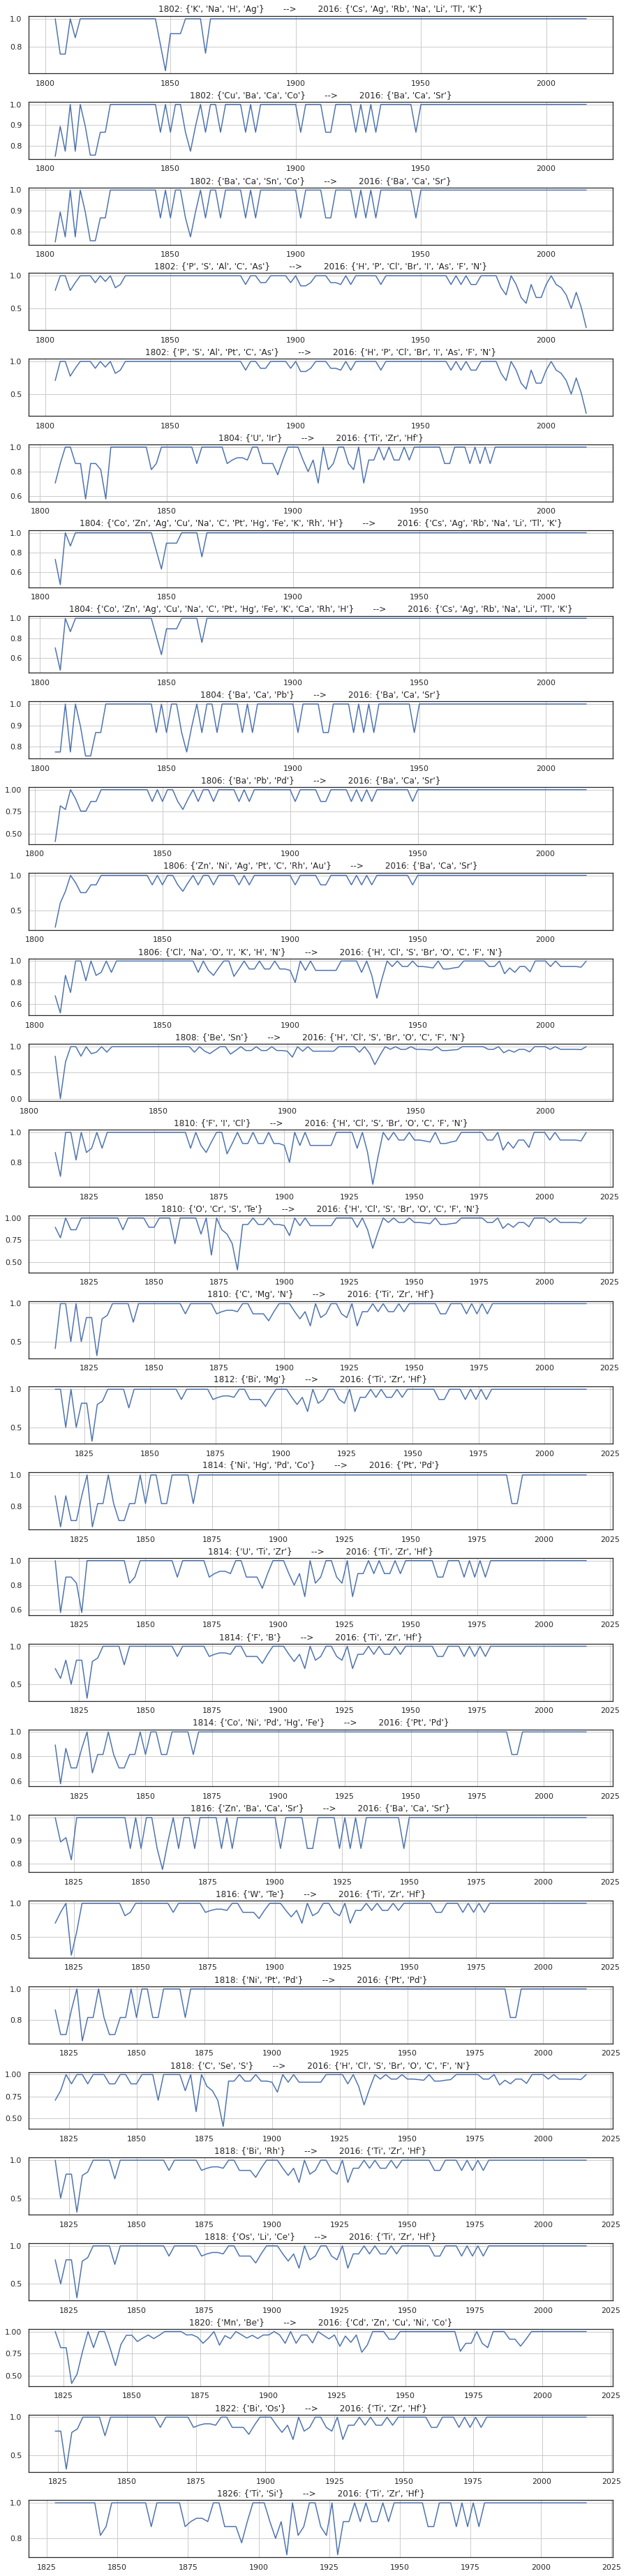

In [22]:
N=30
fig,ax = plt.subplots(N,1,figsize=(15,2*N+7),gridspec_kw={'hspace':0.5})
for i,(yr,gr,m2) in enumerate(grpsEvol[:N]):
    xs = np.arange(yr+2,2018,2)
    ax[i].plot(xs,m2[1:])
    ax[i].set_title(f"{yr}: {gr[0]}       -->        {2016}: {gr[-1]}")
    ax[i].grid()
    
plt.show()